## Spatial Data Science (GEO6119)

---
 
# Lab 7 (Part A): Point Pattern Analysis (Descriptive Methods)

In this lab, you will use descriptive methods to analyze point patterns. Specifically, the following methods will be used:
- Standard Distance
- Standard Deviational Ellipse

This lab is modified from [Point Pattern Analysis](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html) in Rey, Arribas-Bel, and Wolf. (2020) [Geographic Data Science with Python](https://geographicdata.science/book/intro.html).


<br>
Instructor: Yi Qiang (qiangy@usf.edu)<br>


---

## 1. Install New Libraries

We will need a new library [pointpats](https://pointpats.readthedocs.io/en/latest/) for this lab.

1. Please open Anaconda Prompt, and use the command `conda activate geo` to activate the "geo" environment that you created before. 

2. Install pointpats using the following command:

    `conda install -c conda-forge pointpats`
    
    Click 'y' and then 'Enter' when asked to proceed.
    
3. Run the following code to import all packages needed in this lab.

In [1]:
import pointpats as ppt
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sbn
from matplotlib.patches import Ellipse, Circle
import matplotlib.pyplot as plt

#set default plot size, you can adjust the [width, height] to make plots fit your screen size
plt.rcParams['figure.figsize'] = [10, 10]

## 2. Read and Explore the Dataset

Read the dataset of airbnb listings to a pandas DataFrame object. These airbnb listings are located in the Big Island, Hawaii. The data is acquired in 2019 from [Inside Airbnb](http://insideairbnb.com/get-the-data.html).

In [2]:
# Read the file into a DataFrame
df = pd.read_csv("other/airbnb.csv")

# Preview the DataFrame
df.head()

,id,host_name,host_since,latitude,longitude,room_type,bathrooms,bedrooms,beds,price,...,cleaning_fee,guests_included,extra_people,has_availability,availability_30,availability_60,availability_90,availability_365,x,y
0,15648,Kelly,4/9/2009,19.459439,-155.882444,Entire home/apt,1.0,1.0,1.0,90,...,$95.00,2,$45.00,t,0,0,0,236,197365.3998,2154202.154
1,39898,Kelly,4/9/2009,19.461308,-155.881116,Entire home/apt,1.0,1.0,1.0,95,...,$95.00,2,$45.00,t,2,2,2,277,197508.3823,2154406.833
2,202338,Ira,8/18/2011,19.435018,-155.223581,Entire home/apt,1.0,1.0,1.0,129,...,NaN,2,$20.00,t,15,27,48,315,266537.2267,2150470.289
3,205804,Kelly,4/9/2009,19.459061,-155.881781,Entire home/apt,1.0,1.0,1.0,90,...,$95.00,1,$10.00,t,0,1,1,250,197434.3846,2154159.088
4,250414,Charles And Corrina,10/19/2011,19.517786,-155.920875,Private room,1.5,1.0,1.0,80,...,$60.00,2,$10.00,t,23,53,82,351,193437.7107,2160733.206


Print data types of all columns in `df`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5108 entries, 0 to 5107
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                5108 non-null   int64  
 1   host_name         5108 non-null   object 
 2   host_since        5108 non-null   object 
 3   latitude          5108 non-null   float64
 4   longitude         5108 non-null   float64
 5   room_type         5108 non-null   object 
 6   bathrooms         5104 non-null   float64
 7   bedrooms          5106 non-null   float64
 8   beds              5106 non-null   float64
 9   price             5108 non-null   int64  
 10  weekly_price      659 non-null    object 
 11  monthly_price     520 non-null    object 
 12  security_deposit  3708 non-null   object 
 13  cleaning_fee      4669 non-null   object 
 14  guests_included   5108 non-null   int64  
 15  extra_people      5108 non-null   object 
 16  has_availability  5108 non-null   object 


The meanings of the columns can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896)

The `longitude` and `latitude` columns are coordinates in the geographic coordinate system (EPSG:4326). The `x` and `y` columns are coordinates in a projected coordinate system (UTM 35N zone, EPSG:32605). We will use the `x` and `y` coordinates to do spatial analysis.

## 3. Mean and Median Center

First, we use `seaborn.jointplot` to map locations of airbnb listings. The `jointplot` function creates a bivariate plot (2D map) with marginal univariate plots (histograms). The histograms at the margins show distributions of airbnb locations along the x and y dimensions respectively.

Note: the basemap is added to `ax1.ax_joint`, which refers to the part inside the box.

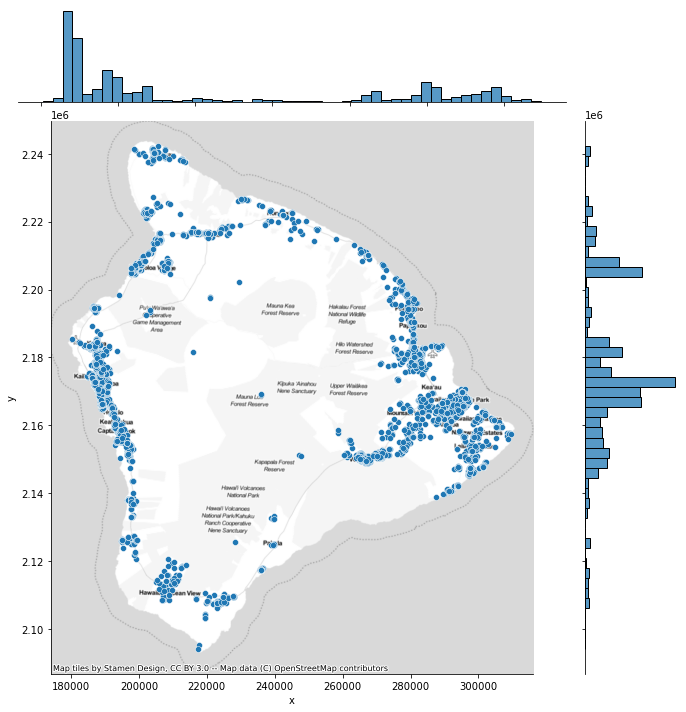

In [4]:
# Import contextily
import contextily as cx

# Generate scatter plot for the airbnb locations, using x and y as coordinates
ax1 = sbn.jointplot(x = df['x'], y = df['y'], marginal_kws = {'bins':50}, height=10)

# Add a basemap to the inner box (map) of the plot
cx.add_basemap(source = cx.providers.Stamen.TonerLite, crs="EPSG:32605", ax = ax1.ax_joint)

Calculate mean center and median center of the airbnbs, using their x and y coordinates.

In [5]:
from pointpats import centrography

mean_center = centrography.mean_center(df[['x','y']])
med_center = centrography.euclidean_median(df[['x','y']])

Add the mean and median centers to the map. 

> Note: `*mean_center` and `*med_center` are simplified syntax that passes two parameters as an array. In regular syntax, you can also write `x = mean_center[0], y = mean_center[1]` and `x = med_center[0], y = med_center[1]` respectively.

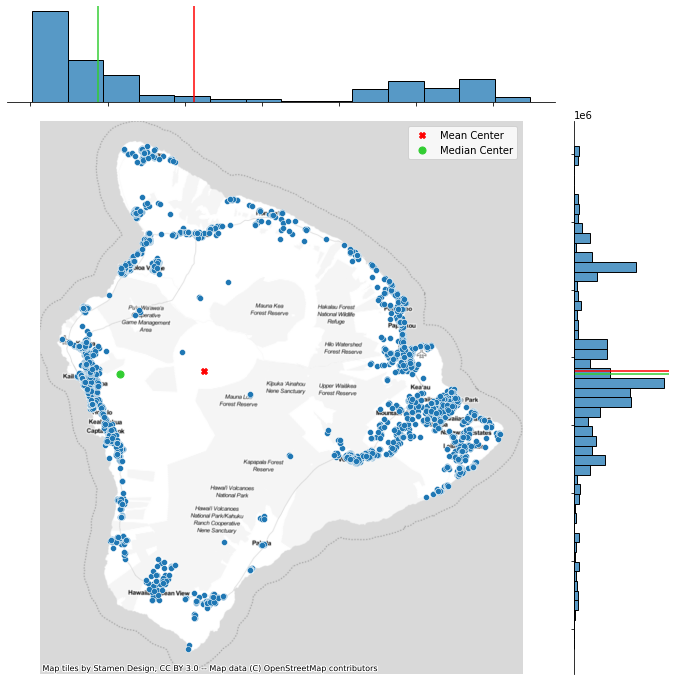

In [6]:
# 1. Generate a map using x and y coordinates
ax1 = sbn.jointplot(x = df['x'], y = df['y'], height=10)

# 2. Add mean and median point
ax1.ax_joint.scatter(*mean_center, color='red', marker='X', label='Mean Center')
ax1.ax_joint.scatter(*med_center, color='limegreen', marker='o', s=50, label='Median Center')

# 3. Add marginal lines for mean point and median point
ax1.ax_marg_x.axvline(mean_center[0], color='red')
ax1.ax_marg_y.axhline(mean_center[1], color='red')
ax1.ax_marg_x.axvline(med_center[0], color='limegreen')
ax1.ax_marg_y.axhline(med_center[1], color='limegreen')

# 4. Add legend
ax1.ax_joint.legend()

# 5. Add basemap
cx.add_basemap(source = cx.providers.Stamen.TonerLite, crs="EPSG:32605", ax = ax1.ax_joint)

# 6. Clean axes
ax1.ax_joint.set_axis_off()


The discrepancy between the two centers is caused by the skew; airbnbs in the west shore of the Island are densely packed, while the airbnb in the east shore are more scattered. In other words, about 50% airbnbs are located in the west shore (west to the green line in the horizontal axis). The scattered airbnbs in the east shore pulls the mean center to the east, relative to the median center.

## Standard Distance and Standard Ellipse

A measure of dispersion that is common in centrography is the standard distance. This measure provides the average distance away from the center of the point cloud (such as measured by the center of mass). This is also simple to compute using pointpats, using the `std_distance` function.

In [7]:
centrography.std_distance(df[['x','y']])

48977.2595931202

This means that, on average, airbnbs are ~49km away from the mean center.

Another helpful visualization is the standard deviational ellipse, or standard ellipse. This is an ellipse drawn from the data that reflects its center, dispersion, and orientation. 

To visualize this, we first compute the axes and rotation using the ellipse function in pointpats:

In [8]:
major, minor, rotation = centrography.ellipse(df[['x','y']])

Next, we create a empty canvas `ax2` and add layers to it one by one.

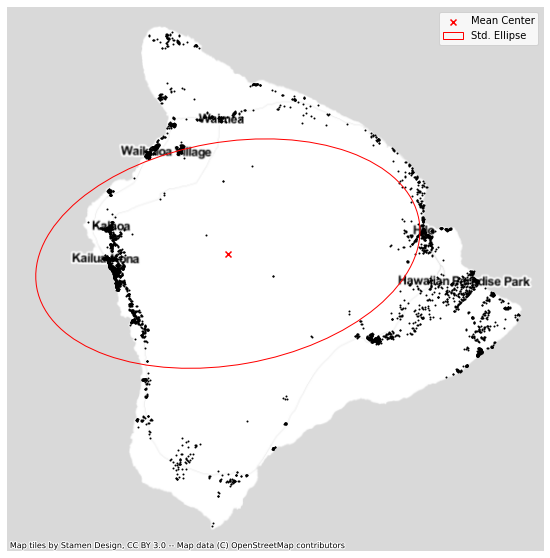

In [9]:
from matplotlib.patches import Ellipse

# Create a canvas "ax2"
ax2 = plt.subplot()

# Plot airbnb locations as black dots
ax2.scatter(x = df['x'], y = df['y'], color = 'black', s = 1)

# Plot the mean center of airbnbs
ax2.scatter(*mean_center, color='red', marker='x', label='Mean Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # major axis of the ellipse (centrography.ellipse only gives half the axis)
                  height=minor*2, # minor axis of the ellipse
                  angle = np.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', # interior color of the ellipse
                  edgecolor='red', # outline color
                  label='Std. Ellipse') # label in the legend

# Add the ellipse
ax2.add_patch(ellipse)

# Add base map
cx.add_basemap(source = cx.providers.Stamen.TonerLite, crs="EPSG:32605", ax = ax2)

# Add legend
ax2.legend()

# Remove gridlines in map
ax2.set_axis_off()

The airbnb listings have three room types: Entire home/apt, Private room, and Shared room. You can use `value_count()` to check the number of listings in the three types.

In [10]:
df['room_type'].value_counts()

Entire home/apt    4185
Private room        879
Shared room          44
Name: room_type, dtype: int64

---

### Question 1 (1pt): Please create a pie chart to show proportions of airbnb listings in different room types.

- You can refer to the example in [Lab 4](https://github.com/qiang-yi/spatial_data_science/blob/main/Lab4_B.ipynb) to create this pie chart.
- The pie chart should look like the following:

![](https://raw.githubusercontent.com/qiang-yi/spatial_data_science/main/image/wk7/pie.jpg)

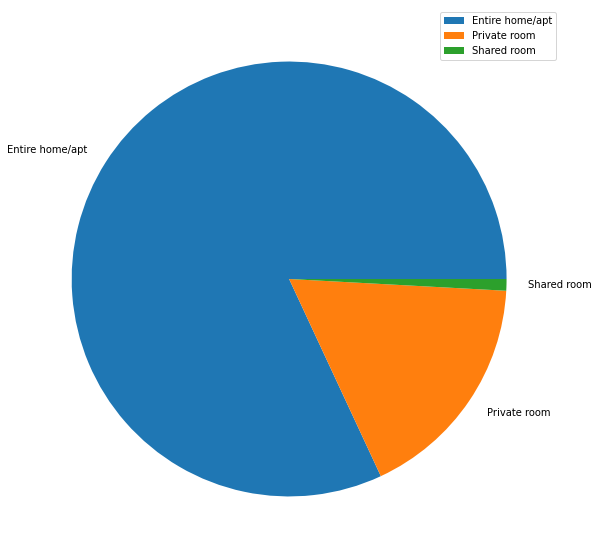

In [11]:
# Group the dataframe by room_type
df_gr = df.groupby(["room_type"]).count()

# Rename a column to 'Listings'. This is to create a meaningful legend in the plot
df_gr = df_gr.rename(columns={'host_name':'Listings'})

# Create a bar chart using the 'Num of children' as the y axis.
ax = df_gr.plot.pie(y='Listings', legend = True, ylabel = "")

### Question 2 (4pts): Please complete the following steps to create mean centers and standard ellipses for the three airbnb types (1: Entire home/apt, 2: Shared room, and 3: Private room).

#### Step 1: Please split the dataframe `df` to three dataframes of airbnb listings of different types.

In [12]:
# Select listings of "Entire home/apt"
df_ef = df[df['room_type']=="Entire home/apt"]

# Select listings of "Shared room"
df_sr = df[df['room_type']=="Shared room"]

# Select listings of "Private room"
df_pr = df[df['room_type']=="Private room"]

#### Step 2: Calculate mean centers of the three types of airbnbs.

In [13]:
# Mean center of entire homes/apts
m_center_ef = centrography.mean_center(df_ef[['x','y']])

# Mean center of shared rooms
m_center_sr = centrography.mean_center(df_sr[['x','y']])

# Mean center of private rooms
m_center_pr = centrography.mean_center(df_pr[['x','y']])

#### Step 3: Calculate major, minor axes and rotation of the three types of airbnbs.

In [14]:
# Major, minor axes and rotation of entire homes/apts
major_ef, minor_ef, rotation_ef = centrography.ellipse(df_ef[['x','y']])

# Major, minor axes and rotation of shared rooms
major_sr, minor_sr, rotation_sr = centrography.ellipse(df_sr[['x','y']])

# Major, minor axes and rotation of private rooms
major_pr, minor_pr, rotation_pr = centrography.ellipse(df_pr[['x','y']])

#### Step 4: Create a map showing mean centers and standard ellipses of the three types of airbnbs.

- Please use green, red and blue colors to differentiate the mean centers and ellipses of the three types.
- Please refer to above examples to write the code. It's most copy and paste work, plus modification of several parameters.
- You may follow the hints in the comments to write the code. You may have a test run of the code after adding a function.

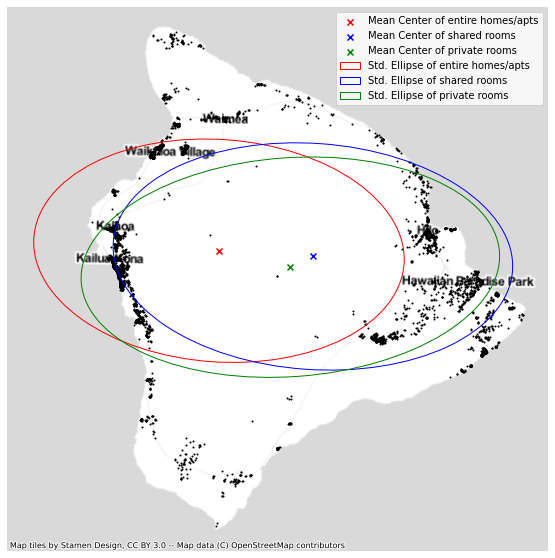

In [15]:
# Create an canvas ax3
ax3 = plt.subplot()

# Plot mean centers of three room types
ax3.scatter(*m_center_ef, color='red', marker='x', label='Mean Center of entire homes/apts')
ax3.scatter(*m_center_sr, color='blue', marker='x', label='Mean Center of shared rooms')
ax3.scatter(*m_center_pr, color='green', marker='x', label='Mean Center of private rooms')

# Plot airbnb locations as black dots
ax3.scatter(x = df['x'], y = df['y'], color = 'black', s = 1)

# Construct the standard ellipse of entire homes/apts
ellipse_ef = Ellipse(xy=m_center_ef, # center the ellipse on our mean center
                  width=major_ef*2, # major axis of the ellipse (centrography.ellipse only gives half the axis)
                  height=minor_ef*2, # minor axis of the ellipse
                  angle = np.rad2deg(rotation_sr), # Angles for this are in degrees, not radians
                  facecolor='none', # interior color of the ellipse
                  edgecolor='red', # outline color
                  label='Std. Ellipse of entire homes/apts') # label in the legend

# Construct the standard ellipse of shared rooms
ellipse_sr = Ellipse(xy=m_center_sr, # center the ellipse on our mean center
                  width=major_sr*2, # major axis of the ellipse (centrography.ellipse only gives half the axis)
                  height=minor_sr*2, # minor axis of the ellipse
                  angle = np.rad2deg(rotation_sr), # Angles for this are in degrees, not radians
                  facecolor='none', # interior color of the ellipse
                  edgecolor='blue', # outline color
                  label='Std. Ellipse of shared rooms') # label in the legend

# Construct the standard ellipse of private rooms
ellipse_pr = Ellipse(xy=m_center_pr, # center the ellipse on our mean center
                  width=major_pr*2, # major axis of the ellipse (centrography.ellipse only gives half the axis)
                  height=minor_pr*2, # minor axis of the ellipse
                  angle = np.rad2deg(rotation_pr), # Angles for this are in degrees, not radians
                  facecolor='none', # interior color of the ellipse
                  edgecolor='green', # outline color
                  label='Std. Ellipse of private rooms') # label in the legend


# Add the ellipse
ax3.add_patch(ellipse_ef)
ax3.add_patch(ellipse_sr)
ax3.add_patch(ellipse_pr)

# Add base map
cx.add_basemap(source = cx.providers.Stamen.TonerLite, crs="EPSG:32605", ax = ax3)

# Add legend
ax3.legend()

# Remove gridlines in map
ax3.set_axis_off()